# Deep Reinforcement Learning for Multi-Agent Environments

---

Let's train agents to hit a ball back and forth in the Tennis environment from Unity ML-Agents! We'll combine deep neural networks and reinforcement learning using a multi-step variant of deep determinsitic policy gradients to teach agents to collaborate on a goal. We'll build up some theory for our methods and implement them to train and evaluate our agents. Let's dive in!

![GIF animation of trained agents in Tennis environment](assets/tennis.gif)

**Figure 1**: GIF animation showing two agents trained to hit a tennis ball back and forth using deep reinforcement learning (multi-step deep determinstic policy gradients). 

Here's a full video showing the trained agent: [https://youtu.be/RLc08qHuOp4](https://youtu.be/RLc08qHuOp4).

## The Environment
---

The Tennis environment in Unity ML-Agents [1] features a tennis court with a net, a ball, and two rackets. Agents control the rackets, which have two continuous action dimensions between -1 and 1. The first action dimension controls position toward and away from the net. The second action dimension controls vertical movement through a jump action. (This action appears binary, initiating a jump at values greater than 0.5.) The observation space has 8 variables representing position and velocity of the agent and the ball. Each state stacks three consecutive observations to help track movement. 

Agents receive a positive reward of +0.1 for hitting the ball over the net and a negative reward of -0.01 if the ball hits the ground or out of bounds. Solving the environment requires a max score between the two agents of 0.5 averaged over the subsequent 100 episodes. Episodes end when the ball hits the ground or out of bounds, so the agents are incentivized to rally the ball back and forth. 

## Methods
---

Let's first introduce some theory and methods useful for training agents in environments with a high-dimensional state spaces and continuous action spaces. We'll build up from basic policy gradients, to actor-critic methods, to deep deterministic policy gradients (DDPG).

### Reinforcement Learning

Reinforcement learning (RL) models an agent acting in an environment as a Markov decision process (MDP) with state space $\mathcal{S}$, action space $\mathcal{A}$, initial state distribution $p_0(s_0)$, and transition function $p(s',r \mid s,a)$. The agent observes a current state $s \in \mathcal{S}$ and selects an action $a \in \mathcal{A}$. Based on environmental dynamics governed by the transition function $p(s',r \mid s,a)$, which is unknown to the agent, the agent transitions to a subsequent state $s' \in \mathcal{S}$ and receives a reward $r$. We aim to use RL to teach the agents to act with policy $\pi : \mathcal{S} \rightarrow \mathcal{A}$ to maximizing cumulative reward, defined as the return $R = \sum_{t=0}^\inf \gamma^t r_{t+1}$ discounted with rate $\gamma$. 

### Value-based Methods

Value-based deep RL methods demonstrated significant progress with the success of deep Q-learning networks (DQN) across a wide range of Atari environments (Minh et al., 2014) [2]. Value-based methods take an indirect approach to learning a policy $\pi$ by first learning a state or action value function. 

* State value function $v^\pi(s) = \mathbb{E}_\pi [R \mid s]$, the expected return $R$ following policy $\pi$ from state $s$. 

* Action value function $q^\pi(s,a) = \mathbb{E}_\pi[R \mid s,a]$, the expected return $R$ for taking action $a$ in state $s$ and following policy $\pi$. 

The action value function provides the "goodness" of each action in a given state. The policy arises by using a max operation to pick the best action. This approach suits environments with discrete action spaces like Atari, where actions are binary inputs from discrete direction and action buttons. In contrast, a task involving finer control such as hitting a tennis ball involves action signals with a continuous range. Finding the maximum action value over a continuous action space adds an iterative optimization task at every time step, significantly increasing computational cost.

### Policy Gradients

Policy gradient methods learn to directly mapping observed states to actions that maximize return. Advantages over value function methods include continuous action spaces, learning stochastic policies, and stability of convergence. Disadvantages include potential for getting stuck in a local optima, poor sample efficiency, and slow convergence.

A neural network function approximator can represent a policy by taking in state values and outputting actions over a continuous range. The agent can learn a parameterized policy $\pi_\theta(a|s)$ for the probability of action $a$ given state $s$ by optimizing parameter $\theta$, where the objective function $J(\theta)$ is the expected return. The environmental dynamics are unknown, so the agent samples returns from the environment to estimate the expected value. Furthermore, the objective of expected return is also the previously mentioned state value $v^\pi(s)$, which can be expressed as the probability-weighted sum of action values.

$$
\begin{align}
& J(\theta) = \mathbb{E}_\pi \left[R_t|s_t=s\right] \\
& J(\theta) = v^\pi(s) \\
& J(\theta) = \sum_{a \in \mathcal{A}} \pi_\theta (a|s) q^\pi(s,a)
\end{align}
$$

Gradient ascent can maximize the objective function $J(\theta)$ by iteratively updating parameters $\theta$ at a learning rate $\alpha$ in the direction of the gradient $\nabla_\theta J(\theta)$:

$$ \theta_{t+1} \leftarrow \theta_t + \alpha \nabla_\theta J(\theta_t) $$

The gradient $\nabla_\theta J(\theta_t) = \nabla_\theta \big[\sum_{a \in \mathcal{A}} \pi_\theta (a|s) q^\pi(s,a) \big]$ initially appears challenging to obtain. The product rule requires taking the gradient on both the policy $\pi_\theta(a|s)$ term (straightforward) and action value $q^\pi(s,a)$ term (challenging). 
The gradient of the action value function $\nabla_\theta q^\pi(s,a)$ requires knowing how the parameters $\theta$ affect the state distribution, since $q^\pi(s,a) = \sum_{s',r} p(s',r \mid s,a) [r + \gamma v^\pi(s')]$ includes the transition function. Luckily, the policy gradient theorem [3] provides an expression for $\nabla_{\theta} J(\theta)$ that doesn't require the derivative of the state distribution $d^\pi(s)$.

$$
\nabla_{\theta} J(\theta) \propto \sum_{s \in \mathcal{S}} d^\pi(s) \sum_{a \in \mathcal{A}} q^\pi(s,a) \nabla_\theta \pi_\theta(a|s) 
$$

Since following policy $\pi$ results in the appropriate state distribution, we can express the summation over state distribution as the expected value under policy $\pi$ by sampling $s_t \sim \pi$. This form suits our stochastic gradient ascent approach for updating parameters $\theta$ by allowing us to sample the expectation of the gradient as the agent interacts with the environment.

$$
\nabla_{\theta} J(\theta) = \mathbb{E}_\pi \left[ \sum_{a \in \mathcal{A}} q^\pi(s_t,a) \nabla_\theta \pi_\theta(a|s_t) \right]
$$

We can multiply and divide by $\pi_\theta(a|s_t)$ to replace the summation over actions with an expectation under policy $\pi$, sampling $a_t \sim \pi$. Furthermore, we can express the action value function by its definition as the expected discounted return $\mathbb{E}_\pi \left[ R_t \mid s_t, a_t \right]$.

$$
\begin{align}
&\nabla_{\theta} J(\theta) = \mathbb{E}_\pi \left[ \sum_{a \in \mathcal{A}} \pi_\theta(a|s_t) q^\pi(s,a) \frac{\nabla_\theta \pi_\theta(a|s_t)}{\pi_\theta(a|s_t)} \right] \\
&\nabla_{\theta} J(\theta) = \mathbb{E}_\pi \left[ q^\pi(s_t,a_t) \frac{\nabla_\theta \pi_\theta(a_t|s_t)}{\pi_\theta(a_t|s_t)} \right] \\
&\nabla_{\theta} J(\theta) = \mathbb{E}_\pi \left[ R_t \frac{\nabla_\theta \pi_\theta(a_t|s_t)}{\pi_\theta(a_t|s_t)} \right] \\
&\nabla_{\theta} J(\theta) = \mathbb{E}_\pi \left[ R_t \nabla_\theta \log \pi_\theta(a_t|s_t) \right] 
\end{align}
$$

The update for parameters $\theta$ becomes proportional to the return $R_t$, inversely proportional to the action probability $\pi_\theta$ (to counteract frequent actions), and in the direction of the gradient $\nabla_\theta \pi_\theta$. 

$$
\begin{align}
&\theta_{t+1} \leftarrow \theta_t +  \alpha R_t \frac{\nabla_\theta \pi_{\theta_t}(a_t|s_t)}{\pi_{\theta_t}(a_t|s_t)} \\
&\theta_{t+1} \leftarrow \theta_t + \alpha R_t \nabla_\theta \log \pi_{\theta_t}(a_t|s_t)  
\end{align}
$$

This basic policy gradient method is called REINFORCE. Using the Monte Carlo approach of sampling returns to estimate the gradient $\nabla_\theta J(\theta)$ is unbiased but has high variance, making it slow and not sample efficient. Subtracting a baseline from the return is one solution for reducing variance. If the chosen baseline does not vary with action, the expectation doesn't change and remains unbiased. The state value function makes for a good baseline.

We can approximate the true value function $v^\pi(s)$ with a neural network $V_\omega(s_t)$ parameterized by $\omega$, learned using stochastic gradient descent with the objective of minimizing the error $\frac{1}{N} \sum_i (R_t - V_\omega(s))^2$ across a mini-batch of $N$ samples. The value and policy parameters update together at their respective learning rates.

$$
\begin{align}
&\delta_t = R_t - V_\omega(s_t) \\
&\omega_{t+1} \leftarrow \omega_t + \alpha_\omega \delta_t \nabla_\omega V_\omega(s_t) \\
&\theta_{t+1} \leftarrow \theta_t + \alpha_\theta \delta_t \nabla_\theta \log \pi_\theta(a_t|s_t)
\end{align}
$$

The General Advantage Estimation paper by Schulman et al. in 2016 [4] includes an overview of several possible expressions for the policy gradient in Figure 2. Instead of $\delta_t$ used here, they use the symbol $\psi_t$ in the paper.

![Policy Gradient Expressions](assets/pg_expressions.png)
**Figure 2**:  Several expressions for the policy gradient from Schulman et al. [4]

### Actor-Critic

We can further utilize the value function to improve learning by reducing variance at the cost of introducing bias. Actor-critic methods use the value function to not merely provide a baseline. A "critic" provides a biased value estimate that replaces full sampled returns to guide the policy, which is the "actor". This approach bootstraps a value estimate using an estimate of the subsequent state value obtained with the same function approximator. Bootstrapping reduces variance to speed up learning, but introduces bias due to reliance on an imperfect critic model. 

For example, an actor-critic method can replace the sampled return $R_t$ with an estimate from the temporal-difference (TD) target $r_{t+1} + \gamma V_\omega(s_{t+1})$ using the critic. The network parameters for both the policy (actor) and the value function (critic) are updated with guidance from the critic.

$$
\begin{align}
&\delta_t = R_t - V_\omega(s_t) \\
&\delta_t = \left[ r_{t+1} + \gamma V_\omega(s_{t+1}) \right] - V_\omega(s_t) \\
&\omega_{t+1} \leftarrow \omega_t + \alpha_\omega \delta_t \nabla_\omega V_\omega(s_t) \\
&\theta_{t+1} \leftarrow \theta_t + \alpha_\theta \delta_t \nabla_\theta \log \pi_\theta(a_t|s_t)
\end{align}
$$

This approach doesn't require completing a full trajectory like Monte Carlo.

### Deep Deterministic Policy Gradients (DDPG)

The actor-critic framework allows us to combine policy gradients with a value-based method like DQN to extend it to continuous action spaces. The techniques introduced in DQN also help deal with issues of error and instability arising from using function approximators with reinforcement learning and policy gradients. 

DQN builds on Q-learning (Watkins, 1989), a classic off-policy TD algorithm. Q-learning updates tabular Q-values toward a TD target computed using the action $a = \text{argmax}_{a} Q(s',a)$ that maximizes the Q-value of the subsequent state.

$$
Q(s,a) \leftarrow Q(s,a) + \alpha [r + \gamma \max_a Q(s',a) - Q(s,a)]
$$

DQN extended Q-learning using deep neural network function approximators for greater representational capacity to handle high-dimensional state spaces. The DQN paper [2] also introduced experience replay buffers and target networks to stabilize learning. 

DDPG (Lillicrap et al., 2016) combines DQN with policy gradient methods using the actor-critic framework to learn a deterministic policy $\mu_\theta(s)$ that acts to approximate Q-learning with guidance from a DQN-like critic $Q_\omega(s,a)$.

#### Deterministic Policy Gradients (DPG)

Policy gradient methods can model deterministic policies $\mu(s)$ in addition to the stochastic policies $\pi(s|a)$ discussed earlier. Deterministic policy gradient methods have better relative sample efficiency since they don't integrate over action space while stochastic policy methods integrate over both state and action space. The DPG paper (Silver et al., 2014) showed deterministic policy gradients are the expectation of the action value gradient and introduced a deterministic version of the policy gradient theorem to provide an expression for $\nabla_\theta J(\theta)$ that doesn't require the derivative of the state distribution $\rho^\mu$.

$$
\begin{align}
&\nabla_\theta J(\mu_\theta) = \mathbb{E}_{s \sim \rho^\mu} \left[ \nabla_{\theta} q^\mu(s,a) \mid _{a=\mu_\theta(s)} \right] \\
&\nabla_\theta J(\mu_\theta) = \mathbb{E}_{s \sim \rho^\mu} \left[ \nabla_\theta \mu_\theta (s) \nabla_a q^\mu (s,a) \mid_{a=\mu_\theta(s)} \right] 
\end{align}
$$

Policy parameters $\theta$ update in proportion to the action value gradient:

$$
\theta_{t+1} \leftarrow \theta_t + \alpha_\theta \nabla_\theta \mu_\theta(s) \nabla_a q^\mu(s,a) \mid_{a=\mu_\theta(s)}
$$

Deterministic policy gradients work with either on-policy or off-policy approaches. For example, an on-policy SARSA update to the critic takes two determinstic actions per time step, using the second action to estimate the value function in the TD target.

$$
\begin{align}
&\delta_t = \left[ r_{t+1} + \gamma Q_\omega(s_{t+1},a_{t+1}) \right] - Q_\omega(s_t,a_t) \\
&\omega_{t+1} \leftarrow \omega_t + \alpha_\omega \delta_t \nabla_\omega Q_\omega(s_t,a_t) 
\end{align}
$$

DDPG uses an off-policy approach and computes the TD target using policy $\mu_\theta(s)$, which approximates the maximization in Q-learning.

$$
\begin{align}
&\delta_t = \left[ r_{t+1} + \gamma Q_\omega(s_{t+1},\mu_\theta (s_{t+1})) \right] - Q_\omega(s_t,a_t) \\
&\omega_{t+1} \leftarrow \omega_t + \alpha_\omega \delta_t \nabla_\omega Q_\omega(s_t,a_t) 
\end{align}
$$

#### Experience Replay Buffer

DDPG uses experience replay introduced in DQN to collect experience tuples $\{(s_i, a_i, s'_i, r_i)\}$ in a large memory buffer $\mathcal{B}$. Experiences are sampled for learning update, eliminating temporal correlation of state observations and improving data efficiency by learning from past experiences. Changes in data distribution are also smoothed out by the random sampling from the replay buffer. A common buffer size across literature seems to be 10^6 experience tuples. 

#### Target Networks

DDPG also draws from DQN's target networks: maintaining a separate copy of the network weights — frozen but periodically updated — for estimating action values in the TD target. The TD target computes an updated value estimate using the latest reward plus a bootstrapped value of the next state. Updating a network based on a target generated from the same evolving network can lead to divergence. Using a frozen or slow changing target network provides a stable fixed target for learning updates by smoothing out short term oscillations.

#### Soft Updates

Target networks for both actor $\theta'$ and critic $\omega'$ can update using a soft approach, where the target network weights change gradually rather than being frozen and replaced periodically by the current networks $\theta$ and $\omega$. 

$$
\begin{align}
&\theta' \leftarrow \tau \theta + (1-\tau)\theta' \\
&\omega' \leftarrow \tau \omega + (1-\tau)\omega' 
\end{align}
$$

The DDPG paper [6] suggests a hyperparameter value of $\tau=0.001$, while others [8] use $\tau=0.005$.

#### Batch Normalization

The scale and range of state values can vary significantly due to environmental conditions and differences in units (position, velocity). Normalizing each dimension to have unit mean and variance across a mini-batch can significantly improve generalization and learning. As suggested in the DDPG paper [6], I apply batch normalization to the state input and before all layers in the actor network. The critic network also uses batch normalization on the state inputs and before all layers not concatenated with action inputs, since we don't want to alter the action signals.

#### Exploratory Action Space Noise

Deterministic policies have a harder time attaining sufficient exploration compared to stochastic polices. Continuous action spaces also make exploration important. Adding noise $\mathcal{N}$ directly to the policy helps encourage exploration.

$$
\mu'(s_t) = \mu_\theta(s_t) + \mathcal{N}(0,\sigma)
$$

The DDPG paper [6] suggests using noise generated from an Ornstein-Uhlenbeck (OU) process so the exploration is temporally correlated. Other researchers [8,11]  have found plain Gaussian noise works just as well. After implementating unique OU noise processes for each agent, I've also found Gaussian noise with a standard deviation 0.1 works just as well for this task. The actions are clipped between [-1, 1].

![DDPG Algorithm](assets/ddpg_algo.png)
**Figure 3:** DDPG (deep deterministic policy gradients) algorithm from Lillicrap et al. [6]

### Twin Delayed DDPG (TD3)

The TD3 algorithm by Fujimoto et al. in 2018 [8] improves on DDPG with three techniques for handling function approximation error: clipped double Q-learning, delayed policy update, and target policy smoothing. 

#### Clipped Double Q-learning

Q-learning is positively biased due to the max operation used for action selection. For example, taking the max over noisy variables that individually have zero mean can produce an output with positive mean. Double Q-learning (Van Hasselt et al., 2010) and Double DQN (Van Hasselt et al., 2016) deal with the overestimation by maintaining two separate value networks to decouple action selection and evaluation. 

Going beyond discrete action spaces, the TD3 paper [8] demonstrates overestimation bias also occurs for continous action spaces in the actor-critic framework. Mitigating bias requires decoupling the action selection (policy) from evalution (value function). We therefore want to use the double Q-learning approach for updating value targets using independent critics.

$$
\begin{align}
&y_1 = r + \gamma Q_{\omega'_2}(s', \mu_{\theta_1}(s') ) \\
&y_2 = r + \gamma Q_{\omega'_1}(s', \mu_{\theta_2}(s') ) 
\end{align}
$$

However, positive bias still occur for actor-critics with double Q-learning because the critics are not completely independent due to related learning targets and a shared replay buffer. The TD3 paper [8] introduced Clipped Double Q-learning, which uses the minimum of the two critics. The less biased critic becomes upper-bounded by the more biased critic.

$$
y_1 = r + \gamma \min_{i=1,2} Q_{\omega'_i}(s', \mu_{\theta_1}(s') )
$$

Clipped double Q-learning mitigates overestimation by favoring underestimation. This trade-off makes sense since underestimation bias aren't prone to spread across learning updates.

In the Tennis environment, clipped double Q-learning improved learning stabilty but also slowed it down slightly.

#### Delayed Policy Updates 

The TD3 paper [8] highlights the interplay between value and policy updates. Poor value estimates can produce policy updates with divergent behavior. They suggest reducing the frequency of policy updates relative to value updates to allow time for value estimates to improve. This reduces the variance in value estimates used to update the policy, producing a better policy that feeds back into better value estimates. The concept is similar to freezing target networks to reduce error. I tried a delay $d=2$ of two critic updates for every actor update as suggested by the TD3 paper [8], but found learning slowed down.

#### Target Policy Smoothing

Deterministic policies can overfit narrow peaks in the value function, increasing variance in the TD target. The TD3 paper [8] address the issue using a regularization technique. Since nearby actions should have similar values, adding some noise to the action in the TD target action evalution should help avoid peaks in the value function. 

$$
\begin{align}
&y = r + \gamma \min_{i=1,2} Q_{\omega'_i}(s', \mu_{\theta'}(s')+\epsilon ) \\
&\epsilon \sim \text{clip}(\mathcal{N}(0,\sigma), -c, c) 
\end{align}
$$

The TD3 paper suggests hyperparamaters of $\sigma=0.2$ clipped at $c=0.5$. For the Tennis environment, I found target policy smoothing did not improve results significantly.

### Multi-Step Returns

Monte Carlo methods calculate returns using full trajectories and are unbiased. However, they have high variance and require many samples. One-step TD methods compute a target using the latest reward plus the subsequent state value estimated using a value function approximator. TD methods reduce variance, but the imperfect value function approximator adds bias. Multi-step returns affect the bias-variance trade-off, reducing bias by incorporating reward samples from a longer trajectory into the TD target. The TD target for n-step return generally has the form:

$$
y_t = \sum_{i=t}^{t+N-1} \gamma^{i-t} r_{i+1} + \gamma^N V(s_{t+N}, a_{t+N})
$$

The TD target for our case with clipped double Q-learning and target policy smoothing becomes:

$$
\begin{align}
&y_t = \sum_{i=t}^{t+N-1} \gamma^{i-t} r_{i+1} + \gamma^N \min_{i=1,2} Q_{\omega'_i}(s'_{t+N}, \mu_{\theta'}(s'_{t+N})+\epsilon ) \\
&\epsilon \sim \text{clip}(\mathcal{N}(0,\sigma), -c, c) 
\end{align}
$$

Using a 5-step return showed improved learning compared to a standard single step. The D4PG paper by Barth-Maron et al. in 2018 [11] introduced several improvements for DDPG, including using multi-step returns. (The authors also used multiple distributed parallel actors, a distributional critic, and prioritized experience replay.) By incorporating rewards across longer trajectories into the TD target, multi-step methods seem to help in sparse reward environments such as the initial learning phase in the Tennis environment.

## Implementation Details
---

#### Centralized actor and critic networks with shared replay memory
The two agents share the same actor and critic networks since they have the same state and action space. The observation variables are defined from the perspective of the agent and relative to the tennis net, so they are symmetric between the two agents. The agents store and learn from experiences in a shared replay buffer.

#### Network architecture
Architecture for the policy and value networks use suggestions from the DDPG paper [6]. Alternative architectures were not explored here, opting for better generalization rather than fine-tuning for this particular environment. The policy network passes the state input (24 dimensions) into two hidden layers (400 and 300 units) with rectified linear unit (ReLU) activation. State inputs along with inputs to each hidden layer used batch normalization to normalize across mini-batch. Tanh activation on the output produce continous action signals between [-1,1] for each of the two action dimensions.

The value network uses a similar architecture but incorporate action inputs in addition to state inputs to represent $Q_\omega(s,a)$. The state input (24 dimensions) passes to a 400 unit hidden layer with ReLU activation. Two nodes for the action inputs add to the first hidden layer (400 + 2 units) before passing to a second hidden layer (300 units) with ReLU activation. The value network outputs a single unit with ReLU activation to represent $Q_\omega(s,a)$. Only the state inputs and inputs to the first hidden layer with 400 units use batch normalization, which does not make sense for layers downstream of combined state and action inputs. 

#### Batch size
The policy and value networks learn off-policy by sampling mini-batches from the replay buffer. The DDPG [6] and TD3 [8] papers use batch sizes of 64 and 100, respectively. The D4PG paper [11] used larger batch sizes of 256 and 512. The MADDPG paper [12] used a batch sizes of 1024. I found a larger batch size of 1024 worked best, with the drawback of increased computation time. 

#### Network update frequency
To improve learning stability, learning updates occur only every 100 time steps (similar to the MADDPG paper [12]). Each time, the networks update 50 times, each with a new mini-batch sampled from the replay buffer. The critic network uses only a single gradient step per mini-batch, but perhaps additional gradient steps would produce a worthwhile improvement to the value estimate. 

#### Gradient clipping
Gradient clipping for the critic helps stabilize learning by prevent gradients from becoming too large.

#### Initial random exploration
Agents take random actions for the initial 5000 time steps to improve exploration and reduce dependency on initial network weights.

#### Adam optimizer weight decay
The DDPG paper [6] suggested using Adam optimization with zero weight decay for the actor and 0.01 for the critic. A critic weight decay of 0.0001 worked much better for this case.

#### Discount factor
I started with a discount factor of 0.99, as used in the DDPG [6] and TD3 [8] papers, with good results. Lowering the discount to 0.95, as used in the MADDPG paper [12], sped up learning.

## Training the Agents
---

Let's train our agents for the Tennis environment. Success requires a max score of 0.5 between the two agents averaged over 100 subsequent episodes.

The agent is implemented in `agent.py`, with the neural networks in `neuralnets.py` and experience replay buffer in `memory.py`.

In [1]:
import numpy as np
import random
import torch
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

from unityagents import UnityEnvironment
from memory import ReplayBuffer
from agent import Agent

import time
import sys
from utils import make_label, save_logs, load_pkl

random_seed = 0

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Load environment
env = UnityEnvironment(file_name='Tennis.app', seed=random_seed)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
n_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]
print('Number of agents: {}'.format(n_agents))
print('Action size: {}'.format(action_size))
print('State size (per agent): {}'.format(state_size))
print('States look like:\n{}'.format(states))

/Users/vincentktam/anaconda/envs/drlnd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Action size: 2
State size (per agent): 24
States look like:
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -6.65278625 -1.5
  -0.          0.          6.83172083  6.         -0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -6.4669857  -1.5
   0.          0.         -6.83172083  6.          0.          0.        ]]


In [2]:
# Instantiate agent
buffer_size = int(1e6) 
batch_size = 1024 
memory = ReplayBuffer(action_size, buffer_size, batch_size, random_seed)
agent = Agent(state_size, action_size, random_seed, memory, batch_size, 
            gamma=0.95, 
            tau=1e-3, 
            LR_actor=1e-3, 
            LR_critic=1e-3, 
            weight_decay=0.0001, 
            n_agents=n_agents, 
            update_every=100, 
            num_updates=50, 
            doubleQ=False, 
            delay_policy=1, 
            smooth_policy=0,
            nstep=5, 
            grad_steps=1)

# Append extra label to filenames
label_append = ''

# Train

def train(n_episodes=3000, max_t=0, print_every=10, random_steps=5000):
    """Train agent
    
    # Parameters 
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode (up to 1000)
        print_every (int): print score every ___ episodes
        random_steps (int): number of initial time steps of random
    """
    scores_deque = deque(maxlen=print_every)  # for status updates
    scores = []  
    avg_score_100 = []  # avg score over next 100
    score_window = deque(maxlen=100)
    for i_episode in range(1, n_episodes+1):
        t_ep_start = time.time()
        env_info = env.reset(train_mode=True)[brain_name]  # reset env    
        #agent.reset()  # Reset OU noise processes
        states = env_info.vector_observations  # get state(s)
        scores_ep = np.zeros(n_agents)  # initialize score(s)
        #for t in range(max_t):
        while True:
            if agent.t < random_steps:
                # Initial random exploration
                actions = np.random.uniform(-1,1, 
                                    size=(agent.n_agents, agent.action_size))
            else:
                actions = agent.act(states)
            env_info = env.step(actions)[brain_name]  # take action(s) in env
            next_states = env_info.vector_observations 
            rewards = env_info.rewards                         
            dones = env_info.local_done  
            agent.step(states, actions, rewards, next_states, dones)
            """
            # Combine states, actions, rewards across agents
            agent.step(states.flatten(), actions.flatten(), 
                       sum(rewards), next_states.flatten(), dones)"""
            scores_ep += env_info.rewards  # accumulate rewards for return(s)
            states = next_states                               
            if np.any(dones):  
                break
        scores_deque.append(np.max(scores_ep)) 
        scores.append(scores_ep)  
        score_window.append(np.max(scores_ep))

        if i_episode >= 100:
            avg_score_100.append(np.mean(score_window))
        print('\rEpisode {}\tScores: {}'\
              .format(i_episode, scores_ep), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

        # Stop if solved
        if np.mean(score_window) >= 0.5:
            print('\nSolved at episode: {}'.format(i_episode - 100))
            break

        if i_episode % print_every == 0:
            timestamp = time.strftime("%Y-%m-%d %H:%M:%S")
            if i_episode < 100:
                print('\r{0:}  t: {1:7.0f}  Ep: {2:4}  Avg Score: {3:5.2f}'\
                    .format(timestamp, agent.t, i_episode, np.mean(scores_deque)))
            else:
                print('\r{0:}  t: {1:7.0f}  Ep: {2:4}  Avg Score: {3:5.2f}  Avg over 100: {4:5.2f}'\
                    .format(timestamp, agent.t, i_episode, np.mean(scores_deque), 
                            np.mean(score_window)))
            
    return scores

t0 = time.time()
scores = train()
t1 = time.time()
print("\nRun time: {:.2f} minutes.".format((t1-t0)/60))

2018-12-24 14:26:16  t:     194  Ep:   10  Avg Score:  0.03
2018-12-24 14:26:17  t:     367  Ep:   20  Avg Score:  0.02
2018-12-24 14:26:18  t:     536  Ep:   30  Avg Score:  0.02
2018-12-24 14:26:18  t:     678  Ep:   40  Avg Score:  0.00
2018-12-24 14:26:45  t:     857  Ep:   50  Avg Score:  0.01
2018-12-24 14:26:59  t:     999  Ep:   60  Avg Score:  0.00
2018-12-24 14:27:24  t:    1157  Ep:   70  Avg Score:  0.00
2018-12-24 14:27:47  t:    1361  Ep:   80  Avg Score:  0.02
2018-12-24 14:28:10  t:    1504  Ep:   90  Avg Score:  0.00
2018-12-24 14:28:21  t:    1660  Ep:  100  Avg Score:  0.01  Avg over 100:  0.01
2018-12-24 14:28:46  t:    1810  Ep:  110  Avg Score:  0.00  Avg over 100:  0.01
2018-12-24 14:28:58  t:    1995  Ep:  120  Avg Score:  0.03  Avg over 100:  0.01
2018-12-24 14:29:32  t:    2203  Ep:  130  Avg Score:  0.03  Avg over 100:  0.01
2018-12-24 14:29:43  t:    2386  Ep:  140  Avg Score:  0.03  Avg over 100:  0.01
2018-12-24 14:30:04  t:    2543  Ep:  150  Avg Score:  

In [3]:
# Save results
from utils import make_label, save_logs, load_pkl
results_dir='results/'
label = make_label(agent, label_append)
logs = save_logs(scores, label, results_dir)

Logs saved for: 
agent_batch1024_updateEvery100_x50_doubleQFalse_delayPol1_smoothPol0_nstep5



In [4]:
# If didn't train, load from logs
if 'scores' not in locals():
    label = 'agent_batch1024_updateEvery100_x50_doubleQFalse_delayPol1_smoothPol0_nstep5'
    filepath = 'results/' + label + '.pkl'
    logs = load_pkl(filepath)
    scores = logs[label] 

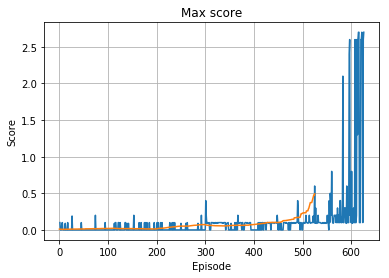

In [5]:
# Visualize learning and save images

# Take average over next 100 scores
scores_max = np.amax(scores, axis=1)
avg_next_100 = []
for i in range(len(scores_max) - 100):
    avg_next_100.append(scores_max[i:i+100].mean())

fig, ax = plt.subplots()
ax.set_title('Max score')
ax.grid(True)
ax.set_ylabel('Score')
ax.set_xlabel('Episode')
ax.plot(np.arange(1, len(scores)+1), [np.max(s_ep) for s_ep in scores])
ax.plot(avg_next_100)
plt.savefig(results_dir + label + '-' + 'scores.png' + '.png')

The blue learning curve shows the max score between the two agents for each episode. The orange curve shows the average across 100 subsequent episodes. The agents solve the environment at episode 526, surpassing the criteria of a 0.5 score averaged over the subsequent 100 episodes. Further training quickly achieves scores above 2.

As a sanity check, let's examine the action values and rewards by sampling from the replay memory.

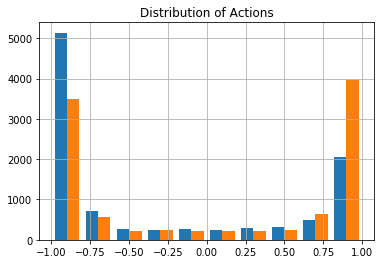

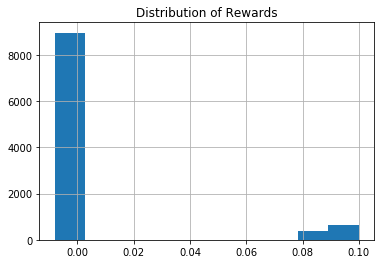

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize action distribution by sampling from memory
experiences = random.sample(memory.buffer, k=10000)

states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

fig, ax = plt.subplots()
ax.set_title('Distribution of Actions')
ax.grid(True)   
ax = plt.hist(actions.numpy())
plt.savefig(results_dir + label + '-' + 'histogram_actions' + '.png')

fig, ax = plt.subplots()
ax.set_title('Distribution of Rewards')
ax.grid(True)   
ax = plt.hist(rewards.numpy())
plt.savefig(results_dir + label + '-' + 'histogram_rewards' + '.png')

The action histogram shows a reasonable distribution of actions across the continuous range between [-1,1]. Most actions occur at the min and max limits, but a good portion occur in between. This also suggests the action space noise is scaled sensibly.  

The reward histogram shows the majority of transitions result in low rewards (0 or -0.01 points). A smaller fraction come from hitting the ball over the net (+0.1 points).

## Testing the Agents
---

Now let's use the trained agents to interact each other and the Tennis environment. 

In [9]:
# Watch trained agent 

# Instantiate agent
buffer_size = int(1e6) 
batch_size = 1024 
memory = ReplayBuffer(action_size, buffer_size, batch_size, random_seed)
agent = Agent(state_size, action_size, random_seed, memory, batch_size, 
            gamma=0.95, 
            tau=1e-3, 
            LR_actor=1e-3, 
            LR_critic=1e-3, 
            weight_decay=0.0001, 
            n_agents=n_agents, 
            update_every=100, 
            num_updates=50, 
            doubleQ=False, 
            delay_policy=1, 
            smooth_policy=0,
            nstep=5, 
            grad_steps=1)

# Load policy net weights saved from training
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))

env_info = env.reset(train_mode=False,)[brain_name]  # reset the env
states = env_info.vector_observations  # get state(s)

for t in range(1000):
    actions = agent.act(states, add_noise=False)  # no action noise
    env_info = env.step(actions)[brain_name]  # take action(s) in env
    states = env_info.vector_observations  # get next state(s)
    rewards = env_info.rewards  
    dones = env_info.local_done                    
    if np.any(dones):  
        break

In [11]:
#env.close()

The GIF animation in Figure 1 previews the first several time steps. Here's a full video showing the trained agents across 1000 time steps: [https://youtu.be/RLc08qHuOp4](https://youtu.be/RLc08qHuOp4).

## Discussion & Next Steps
---

We successfully built agents trained using a multi-step variant of DDPG to hit a tennis ball back and forth without hitting the ground or out of bounds. The agents solve the environment at episode 526. Further training quickly achieves scores up to 2.7 as the agents can rally the ball back and forth for extended periods, as shown in the video. 

Slow initial learning was a challenge. The learning curve shows learning starts slowly for a while but takes-off abruptly. The +0.1 reward for hitting the ball over the net occurs infrequently. Using random exploratory actions at the start helps to collect useful experiences to seed learning. Using a larger batch size also helps, perhaps due to the sparse positive rewards. Learning instabilities also added a fair amount of challenge. Adjusting the network update to be less frequent helped stabilize learning. Using clipped double Q-learning from the TD3 paper also helped stabilize learning, but the other techniques from TD3 seemed to slow learning. 

The next steps include comparing learning performance across multiple random seeds in an ablation study to more rigorously gauge how the individual techniques attempted truly impact learning. More importantly, the current approach to learning in a multi-agent environment using common actor and critic networks with a shared replay memory can only work well with identical agents in a collaborative environment. The next step is to extend to an approach like MADDPG from Lowe et al. [12] to handle more complicated environments with different agents and true competition. 

## References
---

[1] https://github.com/Unity-Technologies/ml-agents

[2] Mnih, Volodymyr, Kavukcuoglu, Koray, Silver, David, Rusu, Andrei A., Veness, Joel, Bellemare, Marc G., Graves, Alex, Riedmiller, Martin, Fidjeland, Andreas K., Ostrovski, Georg, Petersen, Stig, Beattie, Charles, Sadik, Amir, Antonoglou, Ioannis, King, Helen, Kumaran, Dharshan, Wierstra, Daan, Legg, Shane, and Hassabis, Demis. Human-level control through deep reinforcement learning. Nature, 518(7540):529–533, 02 2015. URL http://dx.doi.org/10.1038/nature14236.

[3] Sutton, R. and Barto, A. Reinforcement Learning: An Introduction. MIT Press. 1998.

[4] Schulman, John, Moritz, Philipp, Levine, Sergey, Jordan, Michael, and Abbeel, Pieter. High-dimensional continuous control using generalized advantage estimation. arXiv preprint arXiv:1506.02438, 2015b.

[5] Watkins, C.J.C.H. (1989), Learning from Delayed Rewards (Ph.D. thesis), Cambridge University, 1989. URL http://www.cs.rhul.ac.uk/~chrisw/new_thesis.pdf

[6] Lillicrap, T. P., Hunt, J. J., Pritzel, A., Heess, N., Erez, T., Tassa, Y., Silver, D., and Wierstra, D. Continuous control with deep reinforcement learning. arXiv preprint arXiv:1509.02971, 2015.

[7] Silver, D., Lever, G., Heess, N., Degris, T., Wierstra, D., and Riedmiller, M. Deterministic policy gradient algo- rithms. In International Conference on Machine Learning (ICML), 2014.

[8] Fujimoto, S., van Hoof, H., and Meger, D. Addressing function approximation error in actor-critic methods. arXiv preprint arXiv:1802.09477, 2018.

[9] Hasselt, H. V. Double Q-learning. In Advances in Neural Information Processing Systems (NIPS), pp. 2613–2621, 2010.

[10] Van Hasselt, Hado, Guez, Arthur, and Silver, David. Deep Reinforcement Learning with Double Q-learning. In Proceedings of the Thirtieth AAAI Conference on Artificial Intelligence, 2016. URL http://arxiv.org/abs/1509.06461.

[11] Barth-Maron, G., Hoffman, M. W., Budden, D., Dabney, W., Horgan, D., TB, D., Muldal, A., Heess, N., and Lillicrap, T. Distributional policy gradients. In Proceedings of the
International Conference on Learning Representations (ICLR), 2018.

[12] Lowe, R.; Wu, Y.; Tamar, A.; Harb, J.; Abbeel, P.; and Mordatch, I. 2017. Multi-agent actor-critic for mixed cooperative-competitive environments. arXiv preprint arXiv:1706.02275.